In [1]:
import sys

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split

sys.path.append("../..")

from climateguard.evaluation import evaluation_report

pio.renderers.default = "vscode+png"

## Load the labelled Mediatree transcripts


In [2]:
# Load the ground truth transcripts that were labelled by humans from the Excel file
df = pd.read_csv(
    "../../data/raw/4_channels_review_09_2023_09_2024.xlsx - Claims review.csv",
    index_col=0,
)

# Only keep the records that have a ground truth CARDS label
df = df[~df["cards_ground_truth"].isna()]

df

,channel_name,start,text,quote,claim,analysis,context,cards,cards_ground_truth,quote_is_correct,commentaire_cards,commentaire_quote,Highlight
id,,,,,,,,,,,,,
52061c3902c0257c7bfae7086ae50ea3998fea4204bcd6628588e41d71340dfc,europe1,2023-09-08 19:34:00,Ce n'est pas seulement qu'ils ne les utilisent...,les climatologues ne croient plus leurs termes...,Les climatologues ne croient plus leurs termes...,Cette affirmation pourrait créer un doute sur ...,L'intervenant mentionne une perte de confiance...,5_science_uncertain,0_accepted,TRUE,NaN,termes honnêtes = thermomètre ??,NaN
34a41bf34b35ee91fc147601fb8c21a366a2f568b9060bbb629698dfd9319801,europe1,2023-09-15 19:30:00,"Jusqu'au trente septembre, détaille Sofia au q...",Il y a beaucoup de soldats poneys menteurs à t...,Il y a beaucoup de soldats poneys menteurs à t...,Cette allégation semble suggérer que le réchau...,"Lors d'une conférence de presse au Vietnam, le...",5_science_uncertain,0_accepted,TRUE,"Contexte spécifique de la phrase, les mots de ...",NaN,NaN
0fb8db32982baea27fa4a92220e76331e703d61852c0e8d95550ef6853ffd842,europe1,2023-09-20 07:50:00,On tente d'échapper à une tempête de pluie d'a...,tempête de pluie d'acide mortelle selon l'inrs...,tempête de pluie d'acide mortelle enregistrée ...,L'allégation mentionne une tempête de pluie d'...,Dans une discussion sur un film catastrophe éc...,1_its_not_happening,0_accepted,TRUE,"Contexte spécifique de la phrase, la claim men...",NaN,NaN
4792f93c6614b1e7ef39e301cc6c1d0f4d3d18b9421cc3a9b18aa5c7581c9e02,europe1,2023-10-02 07:54:00,"Les Français n'arrivent pas à se loger, c'est ...",Ça va de l'interdiction des avions d'affaires ...,Diminuer le nombre de vaches et contrôler les ...,Cette affirmation présente des mesures qui n'o...,L'interlocuteur mentionne plusieurs mesures ex...,3_impacts_not_bad,6_proponents_biased,TRUE,NaN,NaN,NaN
74c05fdbca4aeffb643abf0de486b57f8299051d4ef71b58b532791a33aba423,europe1,2023-10-05 19:54:00,Le réchauffement climatique a été collecté à G...,on ne peut pas faire le lien directement avec ...,On ne peut pas faire le lien directement avec ...,Cette assertion minimise le consensus scientif...,Luc Moreau énonce lui-même qu'il est difficile...,2_humans_not_the_cause,2_humans_not_the_cause,TRUE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22d30e47c43d8defe1bdab51e6e4c6374ba982d76de8896c2abb711950121329,tf1,2024-04-23 20:36:00,"Plus chaud de ces dix dernières années, le tem...",Il n'y a plus ni eau ni printemps.,Il n'y a plus ni eau ni printemps.,Cette affirmation semble exagérée et pourrait ...,L'orateur évoque un changement climatique qui ...,1_its_not_happening,0_accepted,FALSE,NaN,"Problème de retranscription, plus automne ni p...",NaN
58feacdc4a4d31023a87bce158ee902d37076d9f5562f3fe41f768ba815b7b6a,tf1,2024-04-28 20:40:00,"Aujourd'hui, ce fameux pacte d'immigration qui...",ce tsunami de normes de contraintes de taxe qu...,Le pacte vert européen organise la décroissance.,Cette affirmation attribue une intention de dé...,Lors d'un discours critique à l'égard des poli...,4_solutions_harmful_unnecessary,4_solutions_harmful_unnecessary,TRUE,NaN,NaN,NaN
6d39a0d45c359fd2183c0f1f001b76c4b60d283240e5c34308b71c22c78217ec,tf1,2024-06-16 18:04:00,"Avec l'aide de nos fournisseurs, si il s'avère...",l'entreprise n'a pas voulu nous dire combien d...,L'huile de palme serait aujourd'hui une soluti...,Cette allégation semble minimiser les impacts ...,Dans un débat sur les pratiques de certains fo...,4_solutions_harmful_unnecessary,0_accepted,TRUE,Potentiellement plutôt du greenwashing,NaN,NaN


In [3]:
# We didn't include the original Mediatree transcript in the Excel file (we should have)
# so we need to do a join to have access to the original text
original = pd.read_parquet(
    "../../data/raw/4_channels_predictions_09_2023_09_2024.parquet"
)["text"].rename("original_text")
df = df.rename(columns={"text": "rewritten_text"}).join(original)

In [4]:
# We noticed (too late) that some rewritten texts were much shorter than their original version.
# We may have inadvertly removed critical information beforr the labelling of the transcripts.
# We could also have hallucinated things that weren't actually said.
# To have trustworthy labels, we will discard the records that have a difference in length greater than 20%
absolute_size_diff_percent = (
    (
        (df["original_text"].str.len() - df["rewritten_text"].str.len())
        / df["original_text"].str.len()
    )
    * 100
).abs()
display(
    absolute_size_diff_percent.quantile([0, 0.25, 0.5, 0.75, 0.8, 0.9, 0.99, 1]).round(
        0
    )
)


print(
    f"We are discarding {(absolute_size_diff_percent > 20).sum()/len(absolute_size_diff_percent):.0%} "
    "of our ground truth records because of shorter/longer rewritten transcription"
)
df = df[absolute_size_diff_percent <= 20]
df = df.rename(columns={"original_text": "text"}).drop(columns="rewritten_text")

0.00     0.0
0.25     6.0
0.50    10.0
0.75    15.0
0.80    17.0
0.90    23.0
0.99    38.0
1.00    71.0
dtype: float64

We are discarding 14% of our ground truth records because of shorter/longer rewritten transcription


In [5]:
# Some transcripts didn't have the right claims highlighted in bold
# The annotators can leave comments regarding this aspect
# However, it turns out that we want to label the full transcript and not the claims themselves
# Therefore, we can ignore these two labels

# # Filter the records that had the correct claim highlighted
# NOTE: not relevant anymore
# df = df[

#     # Only keep the records with a correctly identified quote since the current labelling UX doesn't allow to identify the correct quotes
#      (df["quote_is_correct"] == "TRUE")
#     # Some "commentaire_quote" mention that the identified quote is either incorrect or partially correct, we ignore these records
#     & (df["commentaire_quote"].isna())
# ]

In [6]:
# Only keep the relevant columns
df = df[
    [
        "text",
        "cards_ground_truth",
        "cards",
    ]
].rename(
    columns={
        "cards_ground_truth": "cards_true",
        "cards": "cards_pred",
    }
)

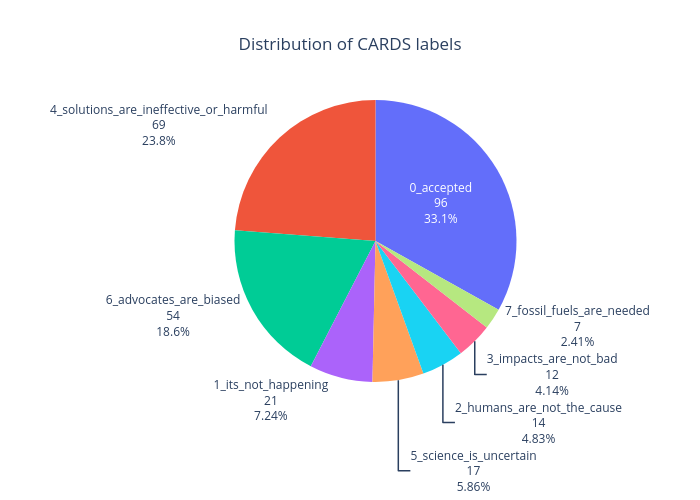

In [7]:
# Renaming some CARDS labels to something better
rename_map = {
    "2_humans_not_the_cause": "2_humans_are_not_the_cause",
    "3_impacts_not_bad": "3_impacts_are_not_bad",
    "4_solutions_harmful_unnecessary": "4_solutions_are_ineffective_or_harmful",
    "5_science_uncertain": "5_science_is_uncertain",
    "6_proponents_biased": "6_advocates_are_biased",
    "7_fossil_fuels_needed": "7_fossil_fuels_are_needed",
}
df["cards_true"] = df["cards_true"].replace(rename_map)
df["cards_pred"] = df["cards_pred"].replace(rename_map)

# Show the distribution of labels
cards_count = df["cards_true"].value_counts().sort_index()
go.Figure(
    go.Pie(
        labels=cards_count.index,
        values=cards_count.values,
        textinfo="label+value+percent",
        showlegend=False,
    ),
    go.Layout(title="Distribution of CARDS labels", title_x=0.5, width=700, height=500),
)

## Train/Test split


In [8]:
# To avoid overfitting the LLM prompts to the transcripts we have labelled we will
# do a train/test split, do prompt engineering using the train split, and eventually
# evaluate the generalizability of our prompts on the test split
df_train, df_test = train_test_split(
    df,
    # Since we don't learn any model weights, there is no reason
    # to have a train set larget than the test set
    test_size=0.5,
    # Since the classes are imbalanced, we use stratified sampling
    # to reproduce the same class distribution in each set
    stratify=df["cards_true"],
    # For reproducibility
    random_state=42,
)

## Evaluate the performance of the baseline model on the test set


BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        48
        True       0.67      1.00      0.80        97

    accuracy                           0.67       145
   macro avg       0.33      0.50      0.40       145
weighted avg       0.45      0.67      0.54       145



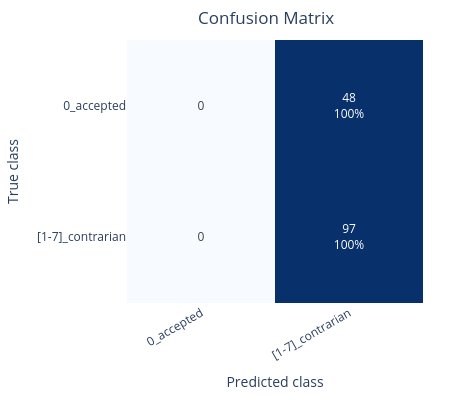

CARDS CLASSIFICATION REPORT

                                        precision    recall  f1-score   support

                            0_accepted       0.00      0.00      0.00        48
                   1_its_not_happening       0.20      0.82      0.32        11
            2_humans_are_not_the_cause       0.40      0.57      0.47         7
                 3_impacts_are_not_bad       0.25      0.83      0.38         6
4_solutions_are_ineffective_or_harmful       0.64      0.53      0.58        34
                5_science_is_uncertain       0.40      0.89      0.55         9
                6_advocates_are_biased       0.89      0.59      0.71        27
             7_fossil_fuels_are_needed       0.75      1.00      0.86         3

                              accuracy                           0.43       145
                             macro avg       0.44      0.65      0.48       145
                          weighted avg       0.40      0.43      0.38       145



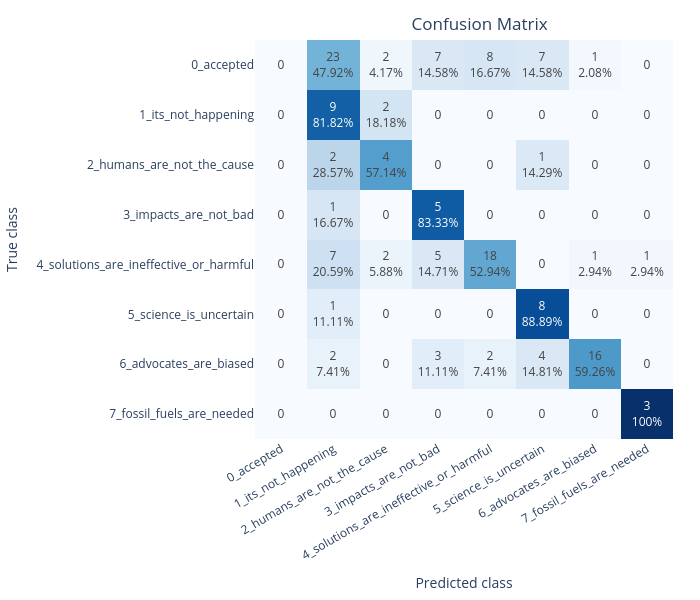

In [9]:
# NOTE: 0_accepted is absent from "cards_pred" in the records we labelled in the Excel file
evaluation_report(df_test["cards_true"], df_test["cards_pred"])

## Save the transcripts as our Mediatree benchmark


In [10]:
df_train.drop(columns="cards_pred").to_csv("../../data/benchmark/mediatree_train.csv")
df_test.drop(columns="cards_pred").to_csv("../../data/benchmark/mediatree_test.csv")